## Promoter region ResNet results

In [71]:
#generic imports
import os
import pathlib
import random
from datetime import datetime
import time
import numpy as np
import pandas as pd
import math
import argparse
import itertools
import os.path

#import constants
from epi_to_express.constants import (
    CHROM_LEN, 
    CHROMOSOMES, 
    SAMPLES,
    SAMPLE_IDS,
    CHROMOSOME_DATA,
    SRC_PATH,
    ASSAYS,
    PROJECT_PATH)

#model imports
import tensorflow as tf
#data loading imports
from epi_to_express.utils import Roadmap3D_tf
from epi_to_express.utils import pearsonR

In [2]:
# 1. --- SETUP PARAMETERS ------------------------------------------------
#paths
SAVE_PATH = pathlib.Path("./model_results")
MOD_SAVE_PATH = pathlib.Path("./model_results/models")
PRED_PATH = pathlib.Path("./model_results/predictions")
PRED_PATH.mkdir(parents=True, exist_ok=True)

#params
pred_resolution = 100# choice of 100, 500, 2000
# 1 Mb of the assay will be considered for the prediction of gene expression
window_size = 6_000
#number of k-fold cross validation
k_fold = 4
#seed
seed = 123
#regression problem
y_type = 'log2RPKM'

# Model specifics - similar to https://www.nature.com/articles/s42256-022-00570-9
batch_size = 64
n_epochs = 100
init_learning_rate = 0.001
lr_decay_factor = 0.2
lr_patience = 3
es_patience = 12
pool_factor=4
kernel_size_factor=3

In [3]:
loss_fn = pearsonR()#tf.keras.losses.mse
losses = []
indic = 0
for assay_i in ASSAYS:
    print(assay_i)
    for cell_i in SAMPLE_IDS:
        print(cell_i)
        print("K fold:")
        # 2. --- Dataset parameters -------------------------------
        #use k-fold cross-validation to retrain each model k times and hold out 
        train_dir = PROJECT_PATH/'chromoformer'/'preprocessing'
        train_meta = train_dir / 'train.csv'
        meta = pd.read_csv(train_meta) \
            .sample(frac=1, random_state=seed) \
            .reset_index(drop=True) # load and shuffle.

        #filter metadat to cell type of interest
        meta = meta[meta.eid == cell_i]

        # Split genes into two sets (train/val).
        genes = set(meta.gene_id.unique())
        n_genes = len(genes)
        #get data for folds separated
        qs = [
            meta[meta.split == 1].gene_id.tolist(),
            meta[meta.split == 2].gene_id.tolist(),
            meta[meta.split == 3].gene_id.tolist(),
            meta[meta.split == 4].gene_id.tolist(),
        ]
        #loop through folds
        for ind,fold in enumerate([x+1 for x in range(k_fold)]):
            print(fold)
            #get fold specific data ----
            train_genes = qs[(fold + 0) % 4] + qs[(fold + 1) % 4] + qs[(fold + 2) % 4]
            val_genes = qs[(fold + 3) % 4]

            #split val_genes in two to get validation and test set
            # train/val split by chrom so do the same for val test
            val_test_genes = val_genes
            val_test_chrom = list(set(meta[meta.gene_id.isin(val_test_genes)]['chrom']))
            val_chrom = val_test_chrom[0:len(val_test_chrom)//2]
            test_chrom = val_test_chrom[len(val_test_chrom)//2:len(val_test_chrom)]
            val_genes = meta[meta.gene_id.isin(val_test_genes) & meta.chrom.isin(val_chrom)]['gene_id'].tolist()
            test_genes = meta[meta.gene_id.isin(val_test_genes) & meta.chrom.isin(test_chrom)]['gene_id'].tolist()
            #----
            #data loaders ----
            test_generator = Roadmap3D_tf(cell_i, test_genes, batch_size=batch_size,
                                          w_prom=window_size, w_max=window_size,
                                          marks = [assay_i],y_type=y_type,
                                          pred_res = pred_resolution,
                                          return_pcres=False)
            
            #get model
            mod_pth = f"{MOD_SAVE_PATH}/covnet_{cell_i}_{'-'.join([assay_i])}_kfold{fold}"
            model = tf.keras.models.load_model(mod_pth, custom_objects={'pearsonR': pearsonR})
            #compile
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_learning_rate),
                          loss=tf.keras.losses.mean_squared_error,
                          metrics=['mse',pearsonR()])
            scores = []
            for ind in range(len(test_generator)):
                #get data
                X,y = test_generator[ind]
                #predict
                output = model.predict(X)
                #eval
                evalu = loss_fn(y, output)
                scores.append(evalu)
            #keep all res in a list index is assay-cell
            scores = [score.numpy() for score in scores]
            losses.append(pd.DataFrame({"fold":[fold]*len(scores),
                                        "assay":[assay_i]*len(scores),
                                        "cell":[cell_i]*len(scores),
                                        "Pearson_R":scores}))

2023-02-08 12:48:07.929332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 12:48:07.942029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 12:48:07.942921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 12:48:07.945049: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

h3k4me1
E003
K fold:
1


2023-02-08 12:48:17.982436: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2023-02-08 12:48:18.865679: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-08 12:48:18.978888: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2
3
4
E004
K fold:
1
2
3
4
E005
K fold:
1
2
3
4
E006
K fold:
1
2
3
4
E007
K fold:
1
2
3
4
E016
K fold:
1
2
3
4
E066
K fold:
1
2
3
4
E087
K fold:
1
2
3
4
E114
K fold:
1
2
3
4
E116
K fold:
1
2
3
4
E118
K fold:
1
2
3
4
h3k4me3
E003
K fold:
1
2
3
4
E004
K fold:
1
2
3
4
E005
K fold:
1
2
3
4
E006
K fold:
1
2
3
4
E007
K fold:
1
2
3
4
E016
K fold:
1
2
3
4
E066
K fold:
1
2
3
4
E087
K fold:
1
2
3
4
E114
K fold:
1
2
3
4
E116
K fold:
1
2
3
4
E118
K fold:
1
2
3
4
h3k9me3
E003
K fold:
1
2
3
4
E004
K fold:
1
2
3
4
E005
K fold:
1
2
3
4
E006
K fold:
1
2
3
4
E007
K fold:
1
2
3
4
E016
K fold:
1
2
3
4
E066
K fold:
1
2
3
4
E087
K fold:
1
2
3
4
E114
K fold:
1
2
3
4
E116
K fold:
1
2
3
4
E118
K fold:
1
2
3
4
h3k27me3
E003
K fold:
1
2
3
4
E004
K fold:
1
2
3
4
E005
K fold:
1
2
3
4
E006
K fold:
1
2
3
4
E007
K fold:
1
2
3
4
E016
K fold:
1
2
3
4
E066
K fold:
1
2
3
4
E087
K fold:
1
2
3
4
E114
K fold:
1
2
3
4
E116
K fold:
1
2
3
4
E118
K fold:
1
2
3
4
h3k36me3
E003
K fold:
1
2
3
4
E004
K fold:
1
2
3
4
E005
K fold:
1


In [3]:
#concat to single dataframe
losses = pd.concat(losses)
#save res
losses.to_csv(f"{PRED_PATH}/blind_test.csv", sep='\t',index=False)

NameError: name 'losses' is not defined

In [4]:
losses = pd.read_csv(f"{PRED_PATH}/blind_test.csv", sep='\t')

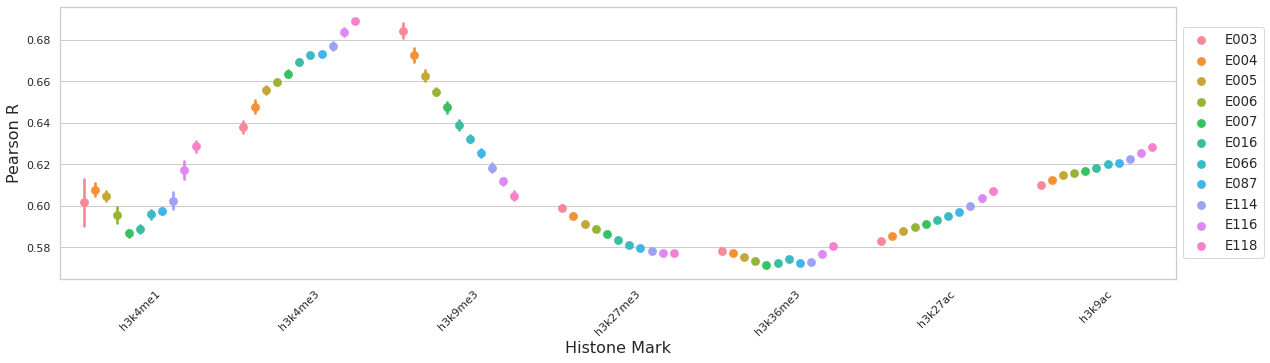

In [5]:
#plot
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 5)})
#sns.set_palette("colorblind")
#same wesanderson palette as used in R plots
extended_palette = ["#9A8822","#F5CDB4","#F8AFA8",
                    "#FDDDA0","#74A089","#85D4E3",
                    #added extra to make 7
                    '#78A2CC']
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

perf_plt = sns.pointplot(hue = "cell",       
            y = "Pearson_R",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses, ci="sd",join=False,
            dodge=0.7
                      )
#perf_plt.set_title('MSE',fontsize=14)
#perf_plt.legend([],[], frameon=False)
# Put the legend out of the figure
perf_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#perf_plt.set(ylim=(-.1, .9))
perf_plt.tick_params(axis='x', rotation=45)

perf_plt.set_xlabel('Histone Mark',fontsize=16)
perf_plt.set_ylabel('Pearson R',fontsize=16)
perf_plt.tick_params(labelsize=11)

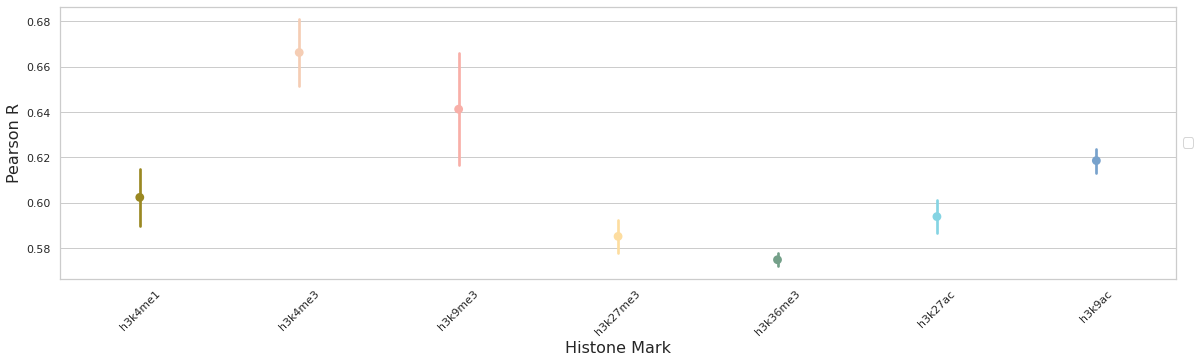

In [5]:
#plot
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 5)})
#same wesanderson palette as used in R plots
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

perf_plt = sns.pointplot(       
            y = "Pearson_R",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses, ci="sd",join=False,
            dodge=0.3, palette=pal)
#perf_plt.set_title('MSE',fontsize=14)
#perf_plt.legend([],[], frameon=False)
# Put the legend out of the figure
perf_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
perf_plt.tick_params(axis='x', rotation=45)

perf_plt.set_xlabel('Histone Mark',fontsize=16)
perf_plt.set_ylabel('Pearson R',fontsize=16)
perf_plt.tick_params(labelsize=11)

Top 3:

1. h3k4me3 - indicative of a promoter region [ref](https://science.sciencemag.org/content/366/6469/1134.fullref-11)
2. h3k9me3 - repressive mark - associated with heterochromatin - initially non-repressive, bookmarks promoters for compaction [ref](https://doi.org/10.1038/s41556-020-0536-6)
3. h3k9ac - associated with active promoters [ref](https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-13-424)

The rest:
    
4. h3k4me1 - commonly associated with distal enhancers [ref](https://www.frontiersin.org/articles/10.3389/fcell.2020.00289/full)
5. h3k27ac - active enhancers and promoters(?) [ref](https://www.frontiersin.org/articles/10.3389/fgene.2020.00817/full)
6. h3k27me3 - repressive mark [ref](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009368)
7. h3k36me3 - heterochromatin [ref](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3166828/)

Other papers tried to study this using SVMs and linear regression (they had a lot of limitations like only considering 1 or 2 cell types) but [one used linear regression](https://www.pnas.org/doi/10.1073/pnas.0909344107#:~:text=Histone%20Modification%20Levels%20Are%20Predictive%20of%20Gene%20Expression%20Across%20Different,within%20a%20given%20cell%20type.) did also find **H3K4me3** to be fairly predictive. 

Also [this paper](https://www.nature.com/articles/s41588-022-01026-x/figures/1) we had in journal club, which predicts histone marks from expression also had some of the highest scores in **H3K4me3** and **h3k9ac** (again less cells types and different data)

Also [Differential contribution to gene expression prediction of histone modifications at enhancers or promoters](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009368) Found **H3K27me3** — a histone modification associated with transcriptional gene repression — was the most prevalent mark in both enhancer and promoter model. Intewresting since H3K27me3 did so poorly here. **H3K4me3** was found to be the next highest mark in this study's promoter model when we consider overlapping marks between our data and theirs. Note theres was mouse ESC so could be differences caused by that too.




### Plot pred versus act - Any visible bias?

In [38]:
predvact = []
for assay_i in ASSAYS:
    print(assay_i)
    for cell_i in SAMPLE_IDS:
        print(cell_i)
        print("K fold:")
        # 2. --- Dataset parameters -------------------------------
        #use k-fold cross-validation to retrain each model k times and hold out 
        train_dir = PROJECT_PATH/'chromoformer'/'preprocessing'
        train_meta = train_dir / 'train.csv'
        meta = pd.read_csv(train_meta) \
            .sample(frac=1, random_state=seed) \
            .reset_index(drop=True) # load and shuffle.

        #filter metadat to cell type of interest
        meta = meta[meta.eid == cell_i]

        # Split genes into two sets (train/val).
        genes = set(meta.gene_id.unique())
        n_genes = len(genes)
        #get data for folds separated
        qs = [
            meta[meta.split == 1].gene_id.tolist(),
            meta[meta.split == 2].gene_id.tolist(),
            meta[meta.split == 3].gene_id.tolist(),
            meta[meta.split == 4].gene_id.tolist(),
        ]
        #loop through folds
        for ind,fold in enumerate([x+1 for x in range(k_fold)]):
            print(fold)
            #get fold specific data ----
            train_genes = qs[(fold + 0) % 4] + qs[(fold + 1) % 4] + qs[(fold + 2) % 4]
            val_genes = qs[(fold + 3) % 4]

            #split val_genes in two to get validation and test set
            # train/val split by chrom so do the same for val test
            val_test_genes = val_genes
            val_test_chrom = list(set(meta[meta.gene_id.isin(val_test_genes)]['chrom']))
            val_chrom = val_test_chrom[0:len(val_test_chrom)//2]
            test_chrom = val_test_chrom[len(val_test_chrom)//2:len(val_test_chrom)]
            val_genes = meta[meta.gene_id.isin(val_test_genes) & meta.chrom.isin(val_chrom)]['gene_id'].tolist()
            test_genes = meta[meta.gene_id.isin(val_test_genes) & meta.chrom.isin(test_chrom)]['gene_id'].tolist()
            #----
            #data loaders ----
            test_generator = Roadmap3D_tf(cell_i, test_genes, batch_size=1,
                                          w_prom=window_size, w_max=window_size,
                                          marks = [assay_i],y_type=y_type,
                                          pred_res = pred_resolution,
                                          return_pcres=False)
            
            #get model
            mod_pth = f"{MOD_SAVE_PATH}/covnet_{cell_i}_{'-'.join([assay_i])}_kfold{fold}"
            model = tf.keras.models.load_model(mod_pth, custom_objects={'pearsonR': pearsonR})
            #compile
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_learning_rate),
                          loss=tf.keras.losses.mean_squared_error,
                          metrics=['mse',pearsonR()])
            act_res = []
            pred_res = []
            for ind in range(len(test_generator)):
                #get data
                X,y = test_generator[ind]
                #predict
                output = model.predict(X)
                #save
                act_res.append(y.numpy()[0][0])
                pred_res.append(output[0][0])
            #keep all res in a list index is assay-cell
            predvact.append(pd.DataFrame({"fold":[fold]*len(act_res),
                                        "assay":[assay_i]*len(act_res),
                                        "cell":[cell_i]*len(act_res),
                                        "actual":act_res,
                                        "prediction":pred_res}))

h3k4me1
E003
K fold:
1
2
3
4
E004
K fold:
1
2
3
4
E005
K fold:
1
2
3
4
E006
K fold:
1
2
3
4
E007
K fold:
1
2
3
4
E016
K fold:
1
2
3
4
E066
K fold:
1
2
3
4
E087
K fold:
1
2
3
4
E114
K fold:
1
2
3
4
E116
K fold:
1
2
3
4
E118
K fold:
1
2
3
4
h3k4me3
E003
K fold:
1
2
3
4
E004
K fold:
1
2
3
4
E005
K fold:
1
2
3
4
E006
K fold:
1
2
3
4
E007
K fold:
1
2
3
4
E016
K fold:
1
2
3
4
E066
K fold:
1
2
3
4
E087
K fold:
1
2
3
4
E114
K fold:
1
2
3
4
E116
K fold:
1
2
3
4
E118
K fold:
1
2
3
4
h3k9me3
E003
K fold:
1
2
3
4
E004
K fold:
1
2
3
4
E005
K fold:
1
2
3
4
E006
K fold:
1
2
3
4
E007
K fold:
1
2
3
4
E016
K fold:
1
2
3
4
E066
K fold:
1
2
3
4
E087
K fold:
1
2
3
4
E114
K fold:
1
2
3
4
E116
K fold:
1
2
3
4
E118
K fold:
1
2
3
4
h3k27me3
E003
K fold:
1
2
3
4
E004
K fold:
1
2
3
4
E005
K fold:
1
2
3
4
E006
K fold:
1
2
3
4
E007
K fold:
1
2
3
4
E016
K fold:
1
2
3
4
E066
K fold:
1
2
3
4
E087
K fold:
1
2
3
4
E114
K fold:
1
2
3
4
E116
K fold:
1
2
3
4
E118
K fold:
1
2
3
4
h3k36me3
E003
K fold:
1
2
3
4
E004
K fold:


In [39]:
#concat to single dataframe
predvact = pd.concat(predvact)
#save res
predvact.to_csv(f"{PRED_PATH}/pred_vs_act.csv", sep='\t',index=False)

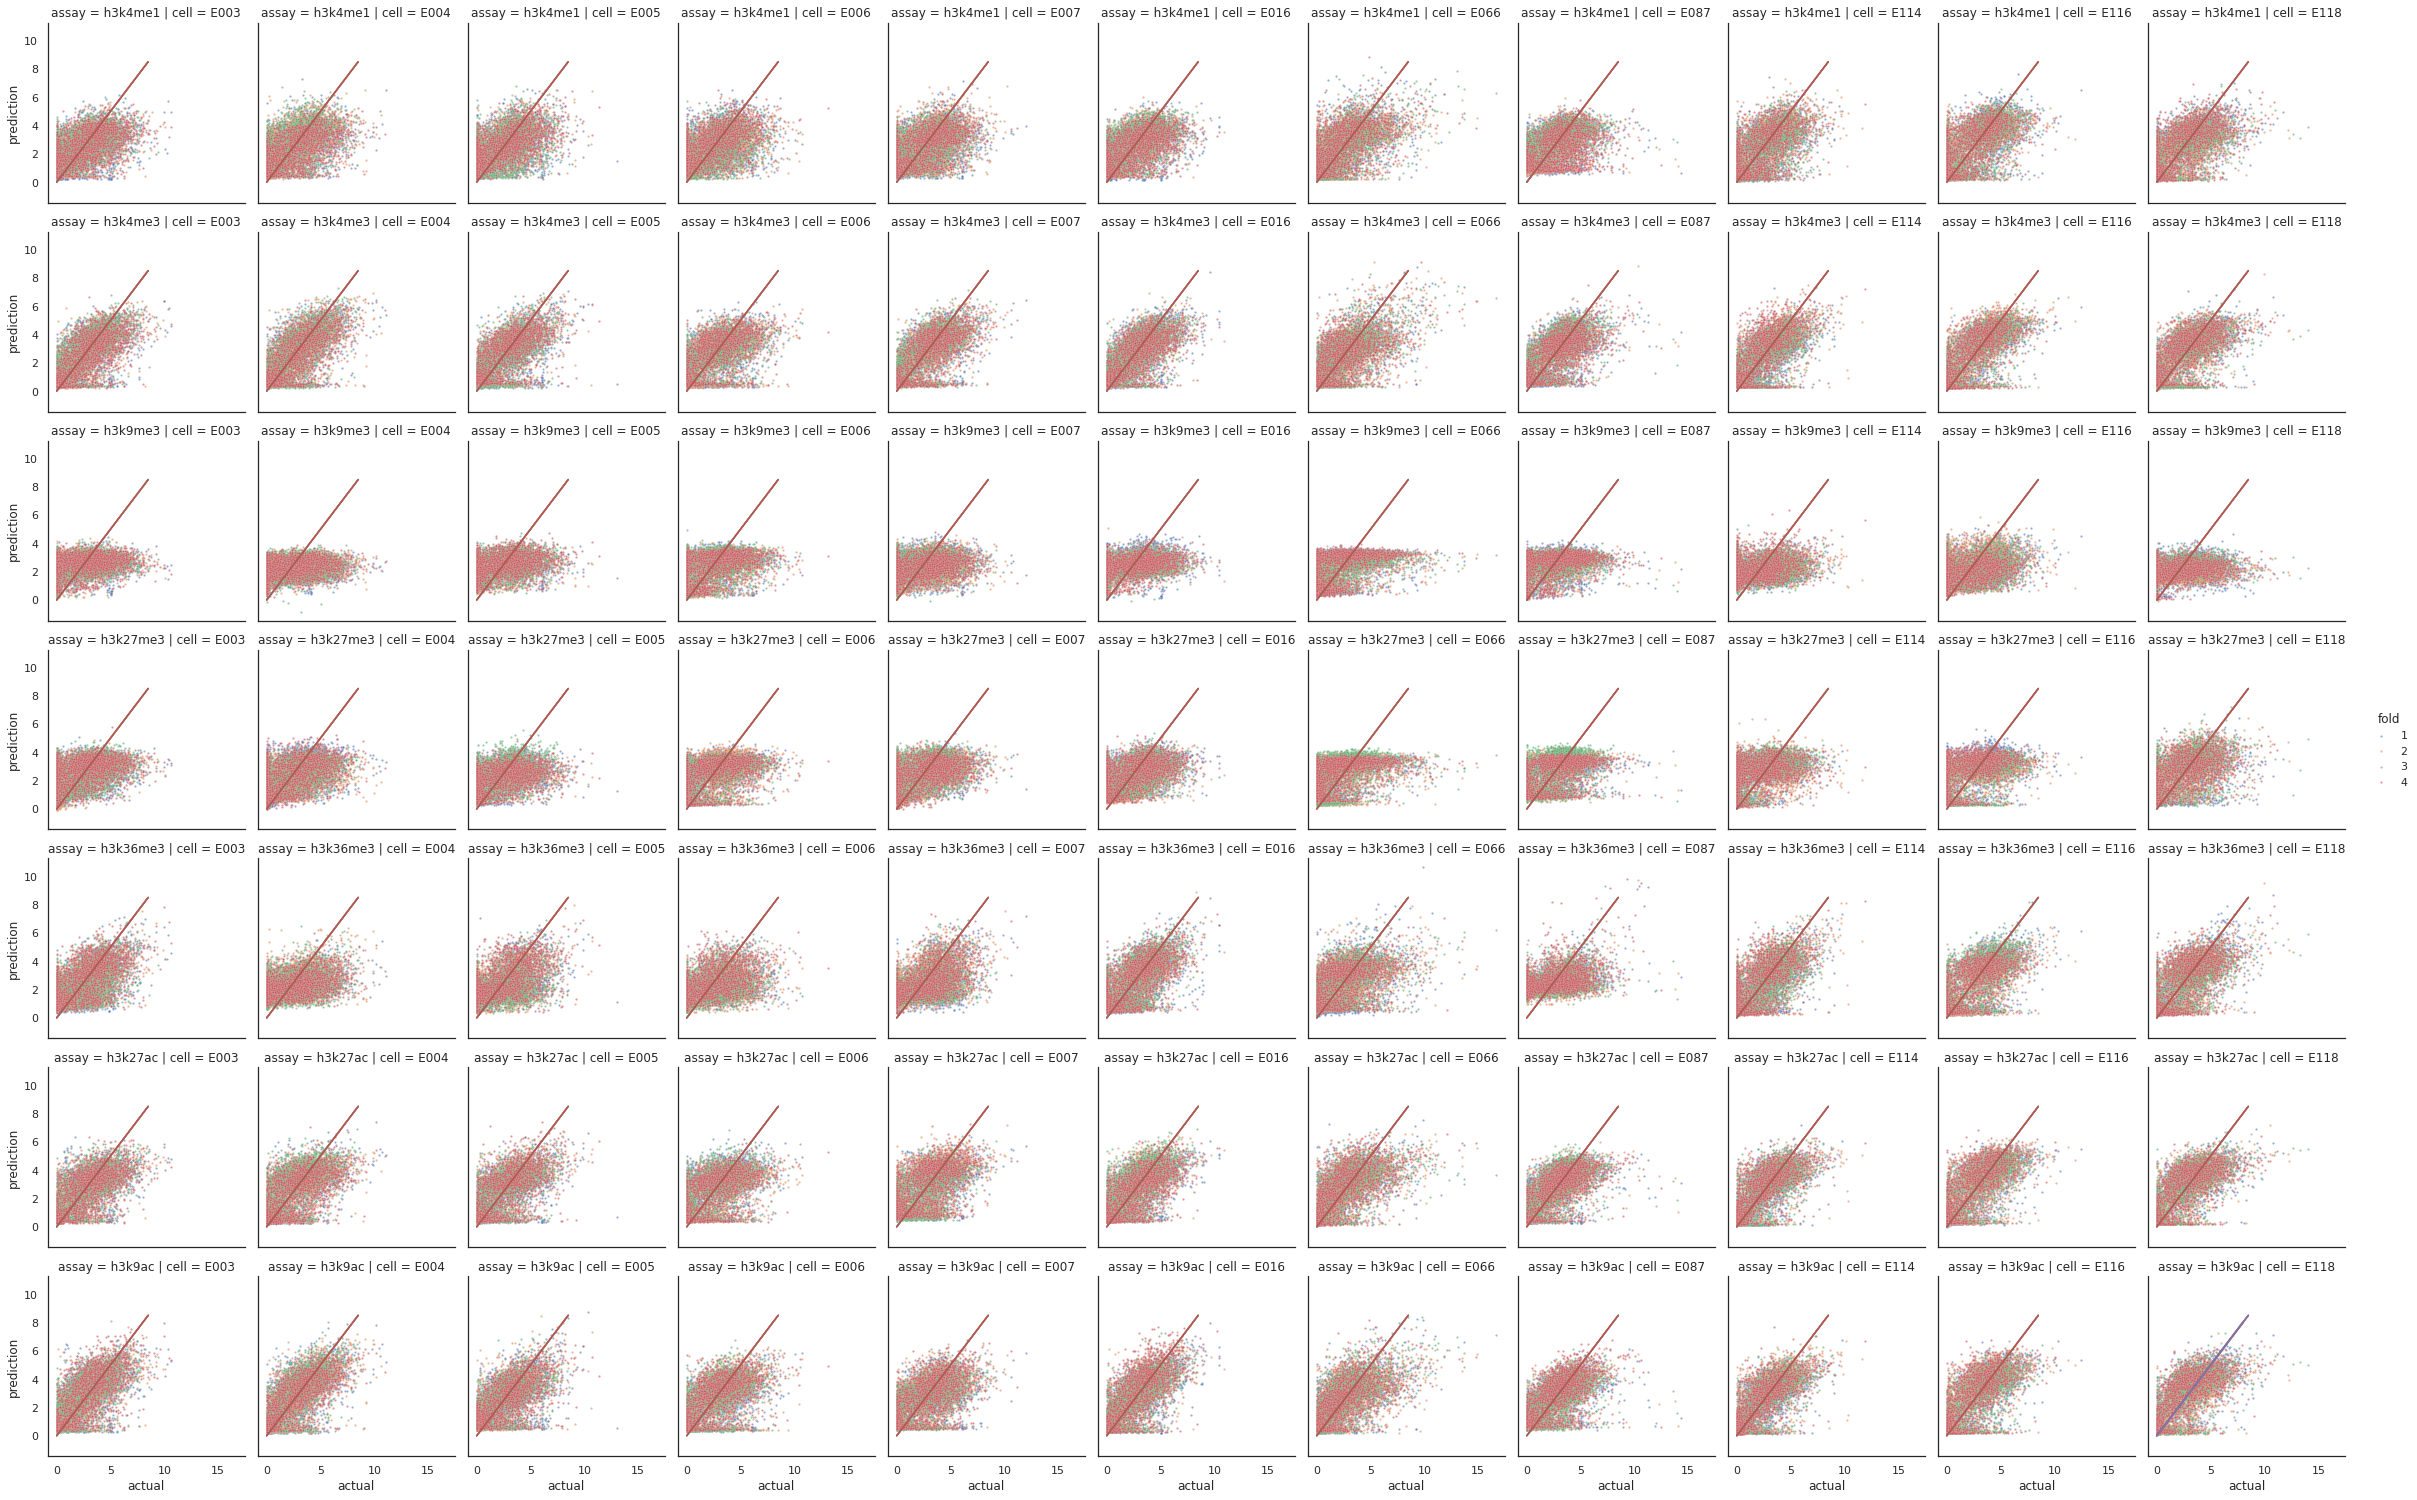

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(19, 17)})
sns.set(font_scale = 1.2)
sns.set_theme(style="white")

pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

sea = sns.FacetGrid(predvact, row='assay',
                    col= "cell",hue='fold')

# map the above form facetgrid with some attributes  
sea.map(sns.scatterplot, 'actual', 'prediction',s=5,alpha=0.6)
plt.plot([0, 8], [0, 8], linewidth=2)
def slope_line(*args, **kwargs):
    x = np.arange(0, 9, .5)
    y = np.arange(0, 9, .5)
    plt.plot(y, x)
sea.map(slope_line)
# adding legend
sea.add_legend()


Results scatter plot of pred expression vs actual:

Look at h3k9me3 and h3k27me3, predictions just won't exceed a specific level even though actuals do


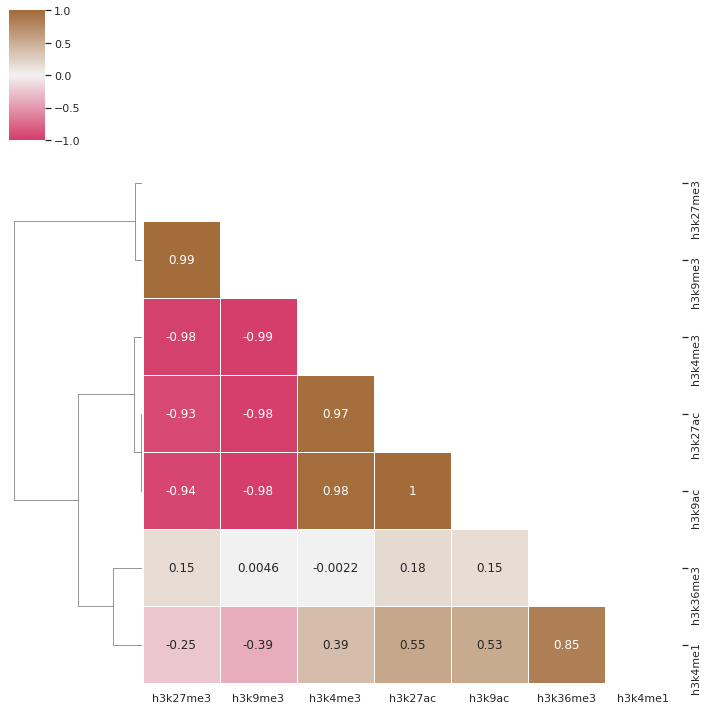

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

losses_agg = losses.copy()
losses_agg['avg_Pearson_R'] = losses_agg.groupby(['assay', 'cell','fold'])['Pearson_R'].transform('mean')
losses_agg = losses_agg.drop_duplicates(subset=['assay', 'cell','fold'])
losses_agg.drop(['Pearson_R'], axis=1,inplace=True)
losses_agg_pov = losses_agg.pivot(index=['cell','fold'],columns='assay', values='avg_Pearson_R').reset_index(drop=True)
losses_agg_pov = losses_agg_pov.rename_axis(None, axis=1)  
losses_agg_pov = losses_agg_pov.rename_axis(None, axis=0)
corr = losses_agg_pov.corr()
# Generate a custom diverging colormap
cmap = sns.diverging_palette(1080, 400, as_cmap=True)
# plot with hierach
g = sns.clustermap(corr,
                   cmap=cmap, vmax=1,vmin=-1, 
                   linewidths=.5, cbar_kws={"shrink": .5},
                   annot=True,
                  )

mask = np.triu(np.ones_like(corr))
values = g.ax_heatmap.collections[0].get_array().reshape(corr.shape)
new_values = np.ma.array(values, mask=mask)
g.ax_heatmap.collections[0].set_array(new_values)
g.ax_col_dendrogram.set_visible(False)

#some numbers still appear, hide them
#from matplotlib.patches import Rectangle
ax = g.ax_heatmap
ax.text(5,0.5,"AAAAAAAAAAAAAAA",backgroundcolor='w',color='w')
ax.text(5,1.5,"AAAAAAAAAAAAAAA",backgroundcolor='w',color='w')
ax.text(5,2.5,"AAAAAAAAAAAAAAA",backgroundcolor='w',color='w')
ax.text(5,3.5,"AAAAAAAAAAAAAAA",backgroundcolor='w',color='w')
ax.text(5,4.5,"AAAAAAAAAAAAAAA",backgroundcolor='w',color='w')

plt.show()

This correlation plot shows how the performance across folds and cells correlates across the model trained on different histone marks. We can notice trends heres so if an model does well in cell type A with histone mark 1 we can check what other histone marks also showed good performance in the same cell type (positive correlation) or conversley didn't do so well (negative).

Results:
  * h3k27ac, h3k4me3 and h3k9ac show near perfect positive correlation - all active promoters ([ref h3k4me3](https://pubmed.ncbi.nlm.nih.gov/28004446/)). This makes sense that h3k27ac as the model would only pick up on it's promoter signal (even though it also indicates enhancers) since the window size is 6k bp around the TSS.
  * h3k27me3 and h3k9me3 show near perfect positive correlation - both repressive marks.
  * These two groups show a near perfect negative correlation with one another. This means that for the cells that active promoter marks are strongly predictive, repressive marks won't be and vice-versa. This is interesting since it could indicate that in certain cell types/states different marks are more indicitive of expression.
  * h3k36me3 (heterochromatin) is highly correlated with h3k4me1 (distal enhancers) but don't seem to be correlated with others (next highest for h3k4me1 is h3k27ac which makes sense)
  
So we should look to see if there is anydistinguishing feature across cell types driving when certain histone mark types predict better  

In [12]:
#first get perf rank for each hist mark so can prove, hist marks in the two groups discussed above is the same
#and the opposite to one another i.e. backing up the corr results
#get average of folds
losses_agg_ca = losses_agg.copy()
losses_agg_ca['avg_Pearson_R'] = losses_agg_ca.groupby(['assay', 'cell'])['avg_Pearson_R'].transform('mean')
losses_agg_ca = losses_agg_ca.drop_duplicates(subset=['assay', 'cell'])
losses_agg_ca.sort_values(['assay','avg_Pearson_R'],
                       ascending=[True, False],inplace=True)

#check rank prom group
print(losses_agg_ca[losses_agg_ca['assay']=='h3k27ac']['cell'].to_list()==losses_agg_ca[losses_agg_ca['assay']=='h3k4me3']['cell'].to_list())
print(losses_agg_ca[losses_agg_ca['assay']=='h3k27ac']['cell'].to_list()==losses_agg_ca[losses_agg_ca['assay']=='h3k9ac']['cell'].to_list())
act_prom_rank = losses_agg_ca[losses_agg_ca['assay']=='h3k27ac']['cell'].to_list()
#check rank repress group
print(losses_agg_ca[losses_agg_ca['assay']=='h3k27me3']['cell'].to_list()==losses_agg_ca[losses_agg_ca['assay']=='h3k9me3']['cell'].to_list())
#last position is diff.......
repres_rank = losses_agg_ca[losses_agg_ca['assay']=='h3k9me3']['cell'].to_list()
# check reverse of active promoters' rank same as repressive marks' rank
print(list(reversed(act_prom_rank))==repres_rank)

True
True
False
True


### Hypothesis: Performance increasing, the more differentiated the cell?

Numbers from ROADMAP match performance, where does ordering from ROADMAP come from?

Rank of perf on ESC derived surronded by perf on ESC undiff

ESDR.H1.BMP4.MESO - first step of diff 
ESDR.H1.BMP4.TROP - 4 days after fert (very early), first cells to diff, derives from ESC
ESC.H1 - 4/5 days after fert 
ESDR.H1.MSC	- Mesenchymal Stem Cells
ESC.HUES64 - Human embryonic stem cell line derived from human blastocysts
ESDR.H1.NEUR.PROG - Neural progenitors (more specialised)

All derived ESC from E003

In [24]:
rm_meta

,Comments,Epigenome ID (EID),ORDER,GROUP,COLOR,Epigenome Mnemonic,Under Seq,Quality Rating,Auto Use Train (Core),Manual Use Train (Core),...,ANATOMY,TYPE,LAB\n(Based on 5 core histone marks only),AGE\n(Post Birth in YEARS/ Fetal in GESTATIONAL WEEKS/CELL LINE CL),"SEX\n(Male, Female, Mixed, Unknown)",SOLID / LIQUID,ETHNICITY,Single Donor (SD) /Composite (C),DONOR / SAMPLE ALIAS,CLASS
10,NaN,E118,116,ENCODE2012,#000000,LIV.HEPG2.CNCR,0,1,1,1,...,LIVER,CellLine,BI,NaN,Male,NaN,NaN,SD,HepG2,ENCODE
9,NaN,E116,114,ENCODE2012,#000000,BLD.GM12878,1,0,1,0,...,BLOOD,PrimaryCulture,BI,NaN,Female,NaN,Caucasian,SD,GM12878,ENCODE
8,NaN,E114,112,ENCODE2012,#000000,LNG.A549.ETOH002.CNCR,1,-1,0,0,...,LUNG,CellLine,BI,NaN,Male,NaN,NaN,SD,A549,ENCODE
6,NaN,E087,105,Other,#999999,PANC.ISLT,-1,1,0,0,...,PANCREAS,PrimaryTissue,BI;UCSF-UBC,"Unknown, Unknown, 45Y",Male,SOLID,"Unknown, Unknown, Caucasian",C,pancreatic_islets_normal_0/0/00;pancreatic_isl...,Class 4
7,NaN,E066,108,Other,#999999,LIV.ADLT,1,1,1,1,...,LIVER,PrimaryTissue,BI,Unknown,Mixed,SOLID,Unknown,C,3;4;5,Class 2
0,NaN,E016,7,ESC,#924965,ESC.HUES64,1,1,1,1,...,ESC,PrimaryCulture,BI,CL,Male,NaN,NaN,SD,196;202;BioSam_825,Class 2
2,NaN,E007,15,ES-deriv,#4178AE,ESDR.H1.NEUR.PROG,1,0,1,0,...,ESC_DERIVED,ESCDerived,UCSD,CL,Male,NaN,NaN,SD,NPC-03;NPC-04;NPC-05;NPC-06,Class 1
5,NaN,E006,23,ES-deriv,#4178AE,ESDR.H1.MSC,1,1,1,1,...,ESC_DERIVED,ESCDerived,UCSD,CL,Male,NaN,NaN,SD,MSC-01;MSC-02,Class 1
4,NaN,E005,22,ES-deriv,#4178AE,ESDR.H1.BMP4.TROP,1,1,1,1,...,ESC_DERIVED,ESCDerived,UCSD,CL,Male,NaN,NaN,SD,BMP4-05;BMP4-06;BMP4-09,Class 1
3,NaN,E004,21,ES-deriv,#4178AE,ESDR.H1.BMP4.MESO,1,0,1,0,...,ESC_DERIVED,ESCDerived,UCSD,CL,Male,NaN,NaN,SD,BMP4-03;BMP4-04;BMP4-07;BMP4-08,Class 1


So the rank of performance on the different cells is the same across the two groups and the exact opposite across teh active promoter and repressive mark groups so there must be some attribute of the cells that are driving this.

In [13]:
#load roadmap metadata
rm_meta = pd.read_csv(str(PROJECT_PATH/'metadata/roadmap_metadata.csv'))
rm_meta['Epigenome ID (EID)'] = pd.Categorical(rm_meta['Epigenome ID (EID)'], act_prom_rank)
rm_meta.sort_values('Epigenome ID (EID)',inplace=True)
#now ordered with first, being the top rank for act prom cells
#let's view the cell types rather than ID's
print(rm_meta['Epigenome Mnemonic'].to_list())
#view source
print("---------------")
print(rm_meta['ANATOMY'].to_list())

['LIV.HEPG2.CNCR', 'BLD.GM12878', 'LNG.A549.ETOH002.CNCR', 'PANC.ISLT', 'LIV.ADLT', 'ESC.HUES64', 'ESDR.H1.NEUR.PROG', 'ESDR.H1.MSC', 'ESDR.H1.BMP4.TROP', 'ESDR.H1.BMP4.MESO', 'ESC.H1']
---------------
['LIVER', 'BLOOD', 'LUNG', 'PANCREAS', 'LIVER', 'ESC', 'ESC_DERIVED', 'ESC_DERIVED', 'ESC_DERIVED', 'ESC_DERIVED', 'ESC']


Okay so the cell types that have better performance in the active promoter group of histone marks, are all from primary tissues whereas the repressive marks had better performance in the differentiated Embryonic stem cells (ESCs). So is this a good mark of age of the cell? Perhaps repressive marks fair better before cells fully differentiate whereas active do better after.

Let's plot just to make sure

Adjusted P-Values:  [5.33533353e-120 7.50262794e-081]


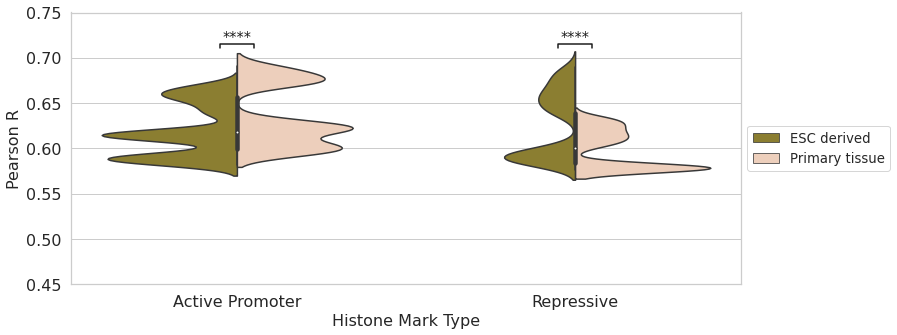

In [34]:
losses_ = losses.copy()
#add histone mark groups
losses_['hist_mark_group'] = np.where(losses_['assay'].isin(['h3k27ac','h3k4me3','h3k9ac']), 
                                     'Active Promoter', 'Other')
losses_['hist_mark_group'] = np.where(losses_['assay'].isin(['h3k27me3','h3k9me3']), 
                                     'Repressive', losses_['hist_mark_group'])

#just include repressive and active promoter marks
losses_ = losses_[losses_['hist_mark_group'].isin(['Active Promoter','Repressive'])]

#add cell anatomy type
losses_ = pd.merge(losses_, rm_meta[["Epigenome ID (EID)", "ANATOMY"]], left_on='cell',
                   right_on="Epigenome ID (EID)", how="left")
losses_['cell_anatomy_grp'] = np.where(losses_['ANATOMY'].isin(['ESC', 'ESC_DERIVED']),
                                       'ESC derived','Primary tissue')

#Mann-Whitney U-Test
import scipy.stats as stats
import statsmodels.stats.multitest as multi
# perform two-sided test.
grps = set(losses_['hist_mark_group'])
p_vals = []
for grp_i in grps:
    mwu = stats.mannwhitneyu(x=losses_[(losses_['hist_mark_group']==grp_i)&
                                       (losses_['cell_anatomy_grp']=="ESC derived")]['Pearson_R'], 
                             y=losses_[(losses_['hist_mark_group']==grp_i)&
                                       (losses_['cell_anatomy_grp']=="Primary tissue")]['Pearson_R'],
                             alternative = 'two-sided')
    p_vals.append(mwu[1])
p_vals_adj = multi.multipletests(p_vals,method='fdr_bh')[1]

print("Adjusted P-Values: ",p_vals_adj)
    
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
# Plot
ax = sns.violinplot(x="hist_mark_group", y="Pearson_R", hue="cell_anatomy_grp",
                    split=True,palette=pal,data=losses_)
# add MWUT annotations
# test 1
x1, x2 = -0.05, 0.05   
y, h, col = losses_['Pearson_R'].max()+0.02, 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 2
x1, x2 = 0.95, 1.05   
y, h, col = losses_['Pearson_R'].max()+0.02, 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel('Histone Mark Type',fontsize=16)
ax.set_ylabel('Pearson R',fontsize=16)
ax.tick_params(labelsize=16)
ax.set(ylim=(0.45, 0.75))

plt.show()

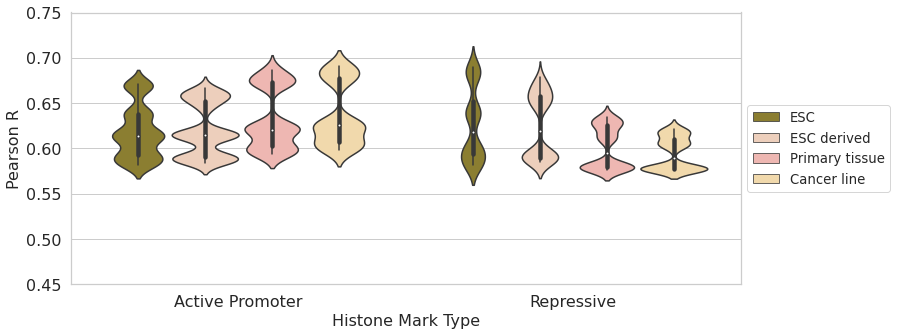

In [37]:
losses_ = losses.copy()
#add histone mark groups
losses_['hist_mark_group'] = np.where(losses_['assay'].isin(['h3k27ac','h3k4me3','h3k9ac']), 
                                     'Active Promoter', 'Other')
losses_['hist_mark_group'] = np.where(losses_['assay'].isin(['h3k27me3','h3k9me3']), 
                                     'Repressive', losses_['hist_mark_group'])

#just include repressive and active promoter marks
losses_ = losses_[losses_['hist_mark_group'].isin(['Active Promoter','Repressive'])]

#add cell anatomy type
losses_ = pd.merge(losses_, rm_meta[["Epigenome ID (EID)", "ANATOMY"]], left_on='cell',
                   right_on="Epigenome ID (EID)", how="left")
losses_['cell_anatomy_grp'] = np.where(losses_['ANATOMY'].isin(['ESC', 'ESC_DERIVED']),
                                       'ESC derived','Primary tissue')

#add cell anatomy type 2
losses_['cell_anatomy_grp2'] = np.where(losses_['ANATOMY'].isin(['ESC']),
                                       'ESC',np.where(losses_['ANATOMY'].isin(['ESC_DERIVED']),'ESC derived',
                                                      np.where(losses_['cell'].isin(['E118','E114']),
                                                               'Cancer line','Primary tissue')))

#Mann-Whitney U-Test
import scipy.stats as stats
import statsmodels.stats.multitest as multi
# perform two-sided test.
grps = set(losses_['hist_mark_group'])
#p_vals = []
#for grp_i in grps:
#    mwu = stats.mannwhitneyu(x=losses_[(losses_['hist_mark_group']==grp_i)&
#                                       (losses_['cell_anatomy_grp']=="ESC derived")]['Pearson_R'], 
#                             y=losses_[(losses_['hist_mark_group']==grp_i)&
#                                       (losses_['cell_anatomy_grp']=="Primary tissue")]['Pearson_R'],
#                             alternative = 'two-sided')
#    p_vals.append(mwu[1])
#p_vals_adj = multi.multipletests(p_vals,method='fdr_bh')[1]

#print("Adjusted P-Values: ",p_vals_adj)
    
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
# Plot
ax = sns.violinplot(x="hist_mark_group", y="Pearson_R", hue="cell_anatomy_grp2",
                    palette=pal,data=losses_)
# add MWUT annotations
# test 1
#x1, x2 = -0.05, 0.05   
#y, h, col = losses_['Pearson_R'].max()+0.02, 0.005, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 2
#x1, x2 = 0.95, 1.05   
#y, h, col = losses_['Pearson_R'].max()+0.02, 0.005, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel('Histone Mark Type',fontsize=16)
ax.set_ylabel('Pearson R',fontsize=16)
ax.tick_params(labelsize=16)
ax.set(ylim=(0.45, 0.75))

plt.show()

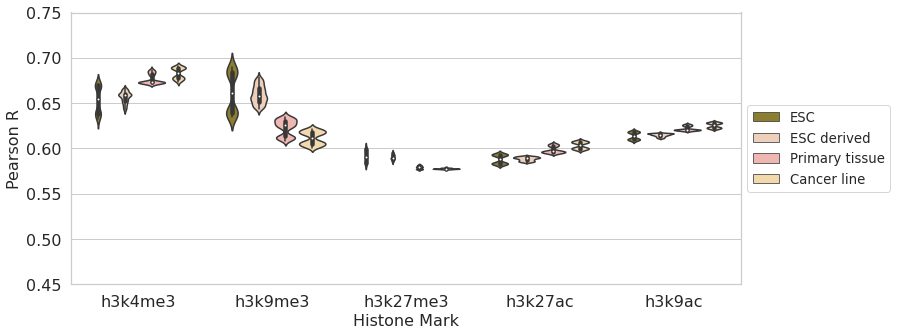

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
# Plot
ax = sns.violinplot(x="assay", y="Pearson_R", hue="cell_anatomy_grp2",
                    palette=pal,data=losses_)
# add MWUT annotations
# test 1
#x1, x2 = -0.05, 0.05   
#y, h, col = losses_['Pearson_R'].max()+0.02, 0.005, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 2
#x1, x2 = 0.95, 1.05   
#y, h, col = losses_['Pearson_R'].max()+0.02, 0.005, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel('Histone Mark',fontsize=16)
ax.set_ylabel('Pearson R',fontsize=16)
ax.tick_params(labelsize=16)
ax.set(ylim=(0.45, 0.75))

plt.show()

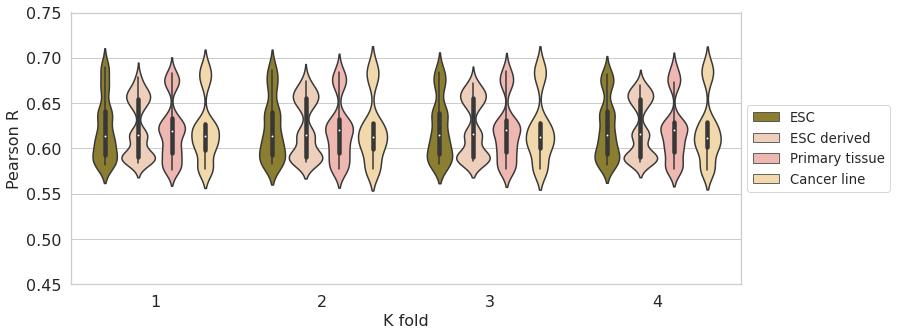

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
# Plot
ax = sns.violinplot(x="fold", y="Pearson_R", hue="cell_anatomy_grp2",
                    palette=pal,data=losses_)
# add MWUT annotations
# test 1
#x1, x2 = -0.05, 0.05   
#y, h, col = losses_['Pearson_R'].max()+0.02, 0.005, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 2
#x1, x2 = 0.95, 1.05   
#y, h, col = losses_['Pearson_R'].max()+0.02, 0.005, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel('K fold',fontsize=16)
ax.set_ylabel('Pearson R',fontsize=16)
ax.tick_params(labelsize=16)
ax.set(ylim=(0.45, 0.75))

plt.show()

### why bimodal? 

Still see even when split cells into two/four groups or even separated by cell or K fold. So it appears this is driven by the genes themselves. It appears certain groups of genes will perform better than others.

This was also found with promoter MPRAs [here](https://www.biorxiv.org/content/10.1101/2023.03.05.531189v1.full#ref-15) - "This bimodal distribution was likely caused by inactive promoters exhibiting little to no activity in the MPRA" "Due to the switch-like (i.e., “on/off”) state of promoters expression values fell into two modes (i.e., a bimodal distribution)" so makes sense that here we see a similar effect on expression.

In [2]:
#generic imports
import os
import pathlib
from datetime import datetime
import time
import numpy as np
import pandas as pd
import math
import itertools

#import constants
from epi_to_express.constants import (
    CHROM_LEN, 
    CHROMOSOMES, 
    SAMPLES,
    SAMPLE_IDS,
    CHROMOSOME_DATA,
    SRC_PATH,
    ASSAYS,
    PROJECT_PATH)

from epi_to_express.utils import pearsonR
#model imports
import tensorflow as tf
#data loading imports
from epi_to_express.utils import Roadmap3D_tf

# 1. --- SETUP PARAMETERS ------------------------------------------------

#what will be used to predict expression
features = ASSAYS

#resolution for training assay
pred_resolution = 100# choice of 100, 500, 2000
# 1 Mb of the assay will be considered for the prediction of gene expression
window_size = 6_000

readable_features = '-'.join(features)

y_type = 'both'


# 2. --- Dataset parameters -------------------------------
train_dir = PROJECT_PATH/'chromoformer'/'preprocessing'
train_meta = train_dir / 'train.csv'
meta = pd.read_csv(train_meta) \
    .reset_index(drop=True)


#two cell groups
rm_meta = pd.read_csv(str(PROJECT_PATH/'metadata/roadmap_metadata.csv'))
cell_grp = rm_meta[['Epigenome ID (EID)','ANATOMY']]
cell_grp['cell_anatomy_grp'] = np.where(cell_grp['ANATOMY'].isin(['ESC', 'ESC_DERIVED']),
                                        'ESC derived','Primary tissue')
#add cell anatomy type 2
cell_grp['cell_anatomy_grp2'] = np.where(cell_grp['ANATOMY'].isin(['ESC']),
                                         'ESC',np.where(cell_grp['ANATOMY'].isin(['ESC_DERIVED']),'ESC derived',
                                                        np.where(cell_grp['Epigenome ID (EID)'].isin(['E118','E114']),
                                                               'Cancer line','Primary tissue')))
esc_cells = cell_grp[cell_grp['cell_anatomy_grp']=='ESC derived']['Epigenome ID (EID)']
prim_tiss_cells = cell_grp[cell_grp['cell_anatomy_grp']=='Primary tissue']['Epigenome ID (EID)']

# 3. --- load data with loader -------------------------------
cells_generators = dict()
genes = list(set(meta.gene_id.unique()))
#go through each group separately
esc_gene = []
esc_gene_lab = []
esc_hists = {i:[] for i in features}
#subset 4 groups
sub_esc_gene = []
sub_esc_gene_lab = []
sub_esc_hists = {i:[] for i in features}
sub_esc_der_gene = []
sub_esc_der_gene_lab = []
sub_esc_der_hists = {i:[] for i in features}
for cell_i in esc_cells:
    print("esc cells:",cell_i)
    #data loaders, one for each cell ----
    cells_generators[cell_i] = Roadmap3D_tf(cell_i, genes, batch_size=1,
                                            w_prom=window_size, w_max=window_size,
                                            marks = features,y_type=y_type,
                                            pred_res = pred_resolution,
                                            shuffle = True,#want order maintained to view all genes
                                            return_pcres=False)
    for tss_i in range(len(cells_generators[cell_i])):
        hist_dat_i = cells_generators[cell_i].__getitem__(tss_i)
        #store gene activity - log2-transformed RPKM
        esc_gene.append(hist_dat_i[1]['log2RPKM'][0][0].numpy())
        esc_gene_lab.append(hist_dat_i[1]['label'][0][0].numpy())
        if(cell_grp[cell_grp['Epigenome ID (EID)']==cell_i]['cell_anatomy_grp2'].tolist()[0]=='ESC'):
            sub_esc_gene.append(hist_dat_i[1]['log2RPKM'][0][0].numpy())
            sub_esc_gene_lab.append(hist_dat_i[1]['label'][0][0].numpy())
        else: #esc deriv
            sub_esc_der_gene.append(hist_dat_i[1]['log2RPKM'][0][0].numpy())
            sub_esc_der_gene_lab.append(hist_dat_i[1]['label'][0][0].numpy())
        #store hist mark activity - mean -log 10 p-val for 6k bp around TSS
        for hist_ind, hist_i in enumerate(features):
            esc_hists[hist_i].append(hist_dat_i[0]['x_p_pred_res'][0,:,hist_ind].numpy().mean())
            if(cell_grp[cell_grp['Epigenome ID (EID)']==cell_i]['cell_anatomy_grp2'].tolist()[0]=='ESC'):
                sub_esc_hists[hist_i].append(hist_dat_i[0]['x_p_pred_res'][0,:,hist_ind].numpy().mean())
            else:
                #esc derv
                sub_esc_der_hists[hist_i].append(hist_dat_i[0]['x_p_pred_res'][0,:,hist_ind].numpy().mean())

prim_tiss_gene = []
prim_tiss_gene_lab = []
prim_tiss_hists = {i:[] for i in features}
#subset 4 groups
sub_prim_tiss_gene = []
sub_prim_tiss_gene_lab = []
sub_prim_tiss_hists = {i:[] for i in features}
sub_cncr_gene = []
sub_cncr_gene_lab = []
sub_cncr_hists = {i:[] for i in features}
for cell_i in prim_tiss_cells:
    print("prim tiss cells:",cell_i)
    #data loaders, one for each cell ----
    cells_generators[cell_i] = Roadmap3D_tf(cell_i, genes, batch_size=1,
                                            w_prom=window_size, w_max=window_size,
                                            marks = features,y_type=y_type,
                                            pred_res = pred_resolution,
                                            shuffle = True,#want order maintained to view all genes
                                            return_pcres=False)
    for tss_i in range(len(cells_generators[cell_i])):
        hist_dat_i = cells_generators[cell_i].__getitem__(tss_i)
        #store gene activity
        prim_tiss_gene.append(hist_dat_i[1]['log2RPKM'][0][0].numpy())
        prim_tiss_gene_lab.append(hist_dat_i[1]['label'][0][0].numpy())                                  
        if(cell_grp[cell_grp['Epigenome ID (EID)']==cell_i]['cell_anatomy_grp2'].tolist()[0]=='Cancer line'):
            sub_cncr_gene.append(hist_dat_i[1]['log2RPKM'][0][0].numpy())
            sub_cncr_gene_lab.append(hist_dat_i[1]['label'][0][0].numpy())
        else:#Primary tissue
            sub_prim_tiss_gene.append(hist_dat_i[1]['log2RPKM'][0][0].numpy())
            sub_prim_tiss_gene_lab.append(hist_dat_i[1]['label'][0][0].numpy())
                                  
        #store hist mark activity - mean -log 10 p-val for 6k bp around TSS
        for hist_ind, hist_i in enumerate(features):
            prim_tiss_hists[hist_i].append(hist_dat_i[0]['x_p_pred_res'][0,:,hist_ind].numpy().mean()) 
            if(cell_grp[cell_grp['Epigenome ID (EID)']==cell_i]['cell_anatomy_grp2'].tolist()[0]=='Cancer line'):
                sub_cncr_hists[hist_i].append(hist_dat_i[0]['x_p_pred_res'][0,:,hist_ind].numpy().mean()) 
            else:#Primary tissue
                sub_prim_tiss_hists[hist_i].append(hist_dat_i[0]['x_p_pred_res'][0,:,hist_ind].numpy().mean())                            
                                                                

/tmp/ipykernel_279033/3839218243.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_grp['cell_anatomy_grp'] = np.where(cell_grp['ANATOMY'].isin(['ESC', 'ESC_DERIVED']),
/tmp/ipykernel_279033/3839218243.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_grp['cell_anatomy_grp2'] = np.where(cell_grp['ANATOMY'].isin(['ESC']),


esc cells: E016


2023-02-28 16:51:56.803505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-28 16:51:58.698296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-28 16:51:58.700227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-28 16:51:58.705246: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

esc cells: E003
esc cells: E007
esc cells: E004
esc cells: E005
esc cells: E006
prim tiss cells: E087
prim tiss cells: E066
prim tiss cells: E114
prim tiss cells: E116
prim tiss cells: E118


In [5]:
#join into on dataframe
agg_hist_exp_prim = pd.DataFrame.from_dict(prim_tiss_hists)
agg_hist_exp_prim['log2RPKM'] = prim_tiss_gene
agg_hist_exp_prim['label'] = prim_tiss_gene_lab
agg_hist_exp_prim['cell_group'] = 'Primary tissue'
agg_hist_exp_esc = pd.DataFrame.from_dict(esc_hists)
agg_hist_exp_esc['log2RPKM'] = esc_gene
agg_hist_exp_esc['label'] = esc_gene_lab
agg_hist_exp_esc['cell_group'] = 'ESC derived'
agg_hist_exp = pd.concat([agg_hist_exp_prim, agg_hist_exp_esc])
#save as checkpoint
#PROJECT_PATH
agg_hist_exp.to_csv(str(PROJECT_PATH/'model_results/checkpoints/agg_hist_exp.csv'), 
                    sep='\t',index=False)
#join 4 grp into on dataframe
#prim & cncr
agg_hist_exp_prim = pd.DataFrame.from_dict(sub_prim_tiss_hists)
agg_hist_exp_prim['log2RPKM'] = sub_prim_tiss_gene
agg_hist_exp_prim['label'] = sub_prim_tiss_gene_lab
agg_hist_exp_prim['cell_group'] = 'Primary tissue'
agg_hist_exp_cncr = pd.DataFrame.from_dict(sub_cncr_hists)
agg_hist_exp_cncr['log2RPKM'] = sub_cncr_gene
agg_hist_exp_cncr['label'] = sub_cncr_gene_lab
agg_hist_exp_cncr['cell_group'] = 'Cancer line'
#esc & esc deriv
agg_hist_exp_esc = pd.DataFrame.from_dict(sub_esc_hists)
agg_hist_exp_esc['log2RPKM'] = sub_esc_gene
agg_hist_exp_esc['label'] = sub_esc_gene_lab
agg_hist_exp_esc['cell_group'] = 'ESC'
agg_hist_exp_esc_derv = pd.DataFrame.from_dict(sub_esc_der_hists)
agg_hist_exp_esc_derv['log2RPKM'] = sub_esc_der_gene
agg_hist_exp_esc_derv['label'] = sub_esc_der_gene_lab
agg_hist_exp_esc_derv['cell_group'] = 'ESC derived'
#join everything
agg_hist_exp_sub = pd.concat([agg_hist_exp_prim, agg_hist_exp_cncr, 
                              agg_hist_exp_esc, agg_hist_exp_esc_derv])
#save as checkpoint
#PROJECT_PATH
agg_hist_exp_sub.to_csv(str(PROJECT_PATH/'model_results/checkpoints/agg_hist_exp_4_grps.csv'), 
                    sep='\t',index=False)

In [15]:
agg_hist_exp = pd.read_csv(str(PROJECT_PATH/'model_results/checkpoints/agg_hist_exp.csv'),sep='\t')
agg_hist_exp_sub = pd.read_csv(str(PROJECT_PATH/'model_results/checkpoints/agg_hist_exp_4_grps.csv'),
                               sep='\t')

Median log2 RPKM Primary tissue: 2.03, ESC Derived: 2.13
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Primary tissue v.s. ESC derived: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.593e-22 U_stat=5.257e+09


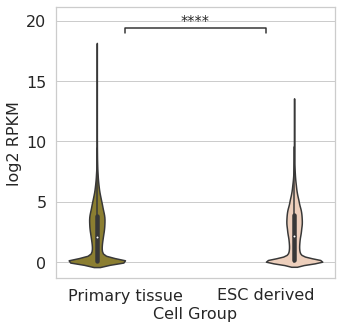

In [16]:
#plot expression across the two cell groups
import seaborn as sns
from statannot import add_stat_annotation

med_prim_tiss = round(np.median(agg_hist_exp[agg_hist_exp['cell_group']=="Primary tissue"]['log2RPKM']),2)
med_esc = round(np.median(agg_hist_exp[agg_hist_exp['cell_group']=="ESC derived"]['log2RPKM']),2)
print(f"Median log2 RPKM Primary tissue: {str(med_prim_tiss)}, ESC Derived: {str(med_esc)}")

sns.set(rc={'figure.figsize':(5, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']
# Plot
ax = sns.violinplot(x="cell_group", y="log2RPKM", hue="cell_group",
                    palette=pal,data=agg_hist_exp)
add_stat_annotation(ax, data=agg_hist_exp, x="cell_group", y="log2RPKM",
                    box_pairs=[("Primary tissue", "ESC derived")],
                    test='Mann-Whitney', text_format='star', #loc='outside', 
                    verbose=2)
# Put the legend out of the figure
ax.legend([],[], frameon=False)
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('log2 RPKM',fontsize=16)
ax.tick_params(labelsize=16)

#plot avg hist -log10 p-val across the two groups

In [17]:
#check proportion of active versus inactive
agg_hist_exp.groupby(['cell_group'])['label'].value_counts(normalize=True)
#I guess this is obvious since the label just says if the expression in the gene 
#is higher than the median for that cell type

cell_group      label
ESC derived     1        0.500026
                0        0.499974
Primary tissue  1        0.500037
                0        0.499963
Name: label, dtype: float64

adjusted p-values:  [2.45446270e-22 2.77894872e-35 0.00000000e+00 8.27168693e-16
 0.00000000e+00 0.00000000e+00 3.74843497e-23]


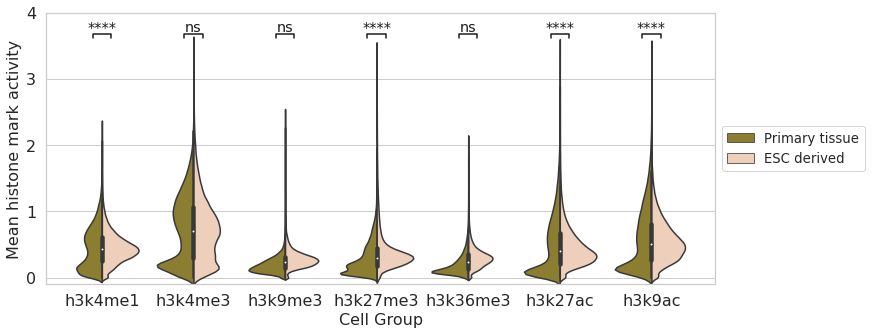

In [18]:
#plot expression across the two cell groups
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

agg_hist_exp_hist = agg_hist_exp.copy()
agg_hist_exp_hist.drop(['log2RPKM'], axis=1,inplace=True)
agg_hist_exp_hist.drop(['label'], axis=1,inplace=True)
agg_hist_exp_hist = agg_hist_exp_hist.melt(id_vars=['cell_group'])

# Plot
ax = sns.violinplot(x="variable", y="value", hue="cell_group",
                    palette=pal,split=True,data=agg_hist_exp_hist)
#Mann-Whitney U-Test
import scipy.stats as stats
import statsmodels.stats.multitest as multi
# perform two-sided test.
grps = set(agg_hist_exp_hist['variable'])
p_vals = []
for grp_i in grps:
    mwu = stats.mannwhitneyu(x=agg_hist_exp_hist[(agg_hist_exp_hist['variable']==grp_i)&
                                       (agg_hist_exp_hist['cell_group']=="ESC derived")]['value'], 
                             y=agg_hist_exp_hist[(agg_hist_exp_hist['variable']==grp_i)&
                                       (agg_hist_exp_hist['cell_group']=="Primary tissue")]['value'],
                             alternative = 'two-sided')
    p_vals.append(mwu[1])
p_vals_adj = multi.multipletests(p_vals,method='fdr_bh')[1]
print("adjusted p-values: ", p_vals_adj)

mx_vl = agg_hist_exp_hist['value'].max()+0.08

# add MWUT annotations
# test 1
x1, x2 = -0.1, 0.1   
y, h, col = mx_vl, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 2
x1, x2 = x1+1, x2+1
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

# test 3
x1, x2 = x1+1, x2+1   
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

# test 4
x1, x2 = x1+1, x2+1   
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 5
x1, x2 = x1+1, x2+1   
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

# test 6
x1, x2 = x1+1, x2+1   
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 7
x1, x2 = x1+1, x2+1  
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('Mean histone mark activity',fontsize=16)
ax.tick_params(labelsize=16)
ax.set(ylim=(-0.1, 4))

plt.show()


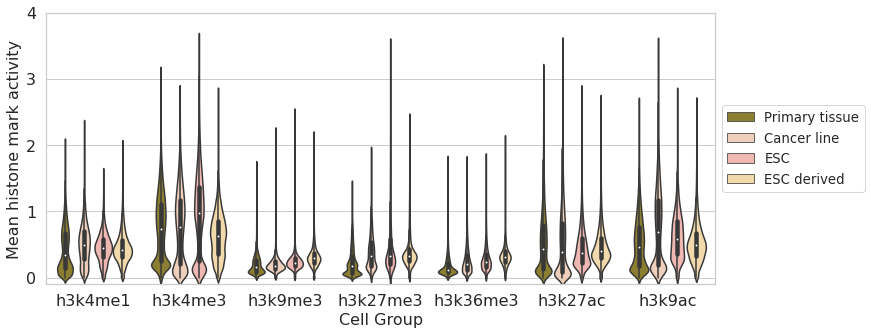

In [7]:
#plot expression across the two cell groups
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

agg_hist_exp_sub_hist = agg_hist_exp_sub.copy()
agg_hist_exp_sub_hist.drop(['log2RPKM'], axis=1,inplace=True)
agg_hist_exp_sub_hist.drop(['label'], axis=1,inplace=True)
agg_hist_exp_sub_hist = agg_hist_exp_sub_hist.melt(id_vars=['cell_group'])

# Plot
ax = sns.violinplot(x="variable", y="value", hue="cell_group",
                    palette=pal,data=agg_hist_exp_sub_hist)

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('Mean histone mark activity',fontsize=16)
ax.tick_params(labelsize=16)
ax.set(ylim=(-0.1, 4))

plt.show()


adjusted p-values:  [2.45446270e-22 2.77894872e-35 0.00000000e+00 8.27168693e-16
 0.00000000e+00 0.00000000e+00 3.74843497e-23]


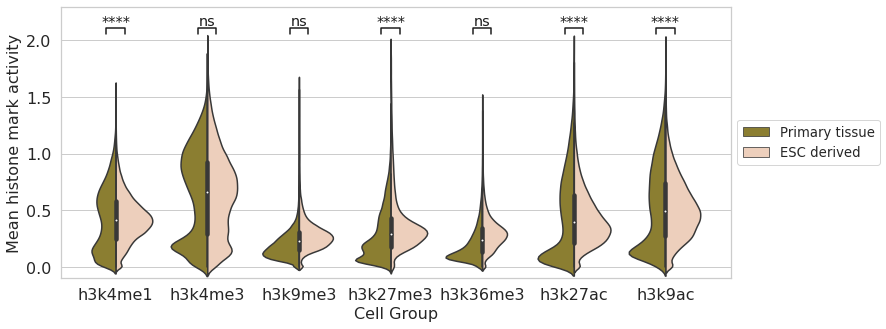

In [19]:
#try with arc sinh transformed hist mark signal to try and rule out seq depth

#plot expression across the two cell groups
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

agg_hist_exp_hist = agg_hist_exp.copy()
agg_hist_exp_hist.drop(['log2RPKM'], axis=1,inplace=True)
agg_hist_exp_hist.drop(['label'], axis=1,inplace=True)
agg_hist_exp_hist = agg_hist_exp_hist.melt(id_vars=['cell_group'])
#arc sinh transform data
agg_hist_exp_hist['value'] = np.arcsinh(agg_hist_exp_hist['value'])

# Plot
ax = sns.violinplot(x="variable", y="value", hue="cell_group",
                    palette=pal,split=True,data=agg_hist_exp_hist)
#Mann-Whitney U-Test
import scipy.stats as stats
import statsmodels.stats.multitest as multi
# perform two-sided test.
grps = set(agg_hist_exp_hist['variable'])
p_vals = []
for grp_i in grps:
    mwu = stats.mannwhitneyu(x=agg_hist_exp_hist[(agg_hist_exp_hist['variable']==grp_i)&
                                       (agg_hist_exp_hist['cell_group']=="ESC derived")]['value'], 
                             y=agg_hist_exp_hist[(agg_hist_exp_hist['variable']==grp_i)&
                                       (agg_hist_exp_hist['cell_group']=="Primary tissue")]['value'],
                             alternative = 'two-sided')
    p_vals.append(mwu[1])
p_vals_adj = multi.multipletests(p_vals,method='fdr_bh')[1]
print("adjusted p-values: ", p_vals_adj)

mx_vl = agg_hist_exp_hist['value'].max()+0.08

# add MWUT annotations
# test 1
x1, x2 = -0.1, 0.1   
y, h, col = mx_vl, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 2
x1, x2 = x1+1, x2+1
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

# test 3
x1, x2 = x1+1, x2+1   
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

# test 4
x1, x2 = x1+1, x2+1   
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 5
x1, x2 = x1+1, x2+1   
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

# test 6
x1, x2 = x1+1, x2+1   
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 7
x1, x2 = x1+1, x2+1  
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('Mean histone mark activity',fontsize=16)
ax.tick_params(labelsize=16)
ax.set(ylim=(-0.1, 2.3))

plt.show()


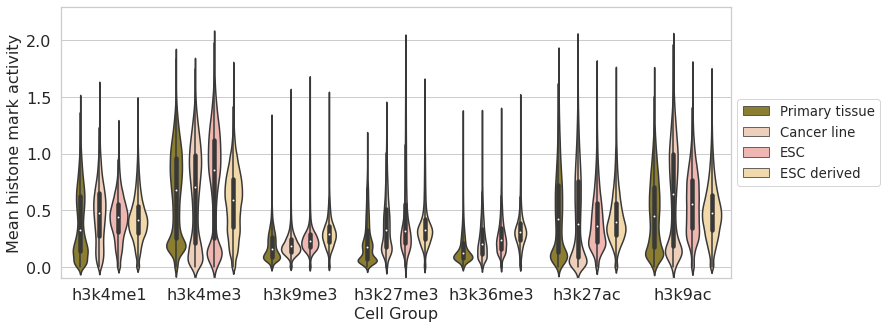

In [8]:
#try with arc sinh transformed hist mark signal to try and rule out seq depth

#plot expression across the two cell groups
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

agg_hist_exp_sub_hist = agg_hist_exp_sub.copy()
agg_hist_exp_sub_hist.drop(['log2RPKM'], axis=1,inplace=True)
agg_hist_exp_sub_hist.drop(['label'], axis=1,inplace=True)
agg_hist_exp_sub_hist = agg_hist_exp_sub_hist.melt(id_vars=['cell_group'])
#arc sinh transform data
agg_hist_exp_sub_hist['value'] = np.arcsinh(agg_hist_exp_sub_hist['value'])

# Plot
ax = sns.violinplot(x="variable", y="value", hue="cell_group",
                    palette=pal,data=agg_hist_exp_sub_hist)

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('Mean histone mark activity',fontsize=16)
ax.tick_params(labelsize=16)
ax.set(ylim=(-0.1, 2.3))

plt.show()


Expression levels are **higher in ESC derived cells** compared to primary tissue but I don't think we should compare expression like this.

One of the two repressive marks (h3k9me3) shows **greater activity in the TSS of ESC cells**. However, so too does **two of the three active marks** (h3k27ac, h3k9ac). This remains the same after arc-sinh transforming the marks so likely not to be a sequencing depth effect.

So expression levels are **higher** in ESC and so too is **histone mark activity levels** but **not proportions of expressed genes**. Note that the higher levels of histone mark activities probably isn't driven by seq depth as arc-sin transforming them gave the same result.

Let's look at histone mark activity across active and inactive genes - using active/inactive definition from the chromoformer paper (based on median gene exp from all cells) - 

whether an expression level of a gene is above the median for the cell or not. This problem formulation was first proposed by [Singh et al.](https://pubmed.ncbi.nlm.nih.gov/27587684/), and it has been so far widely adopted for many studies, including the three aforementioned baseline studies. 

h3k27ac Direction ESC derived - Primary tissue: -0.2035671
h3k4me1 Direction ESC derived - Primary tissue: -0.12643929999999992
h3k9me3 Direction ESC derived - Primary tissue: 0.10273666499999998
h3k4me3 Direction ESC derived - Primary tissue: -0.16308157499999987
h3k36me3 Direction ESC derived - Primary tissue: 0.10348960500000001
h3k27me3 Direction ESC derived - Primary tissue: 0.13286292000000002
h3k9ac Direction ESC derived - Primary tissue: -0.1821530899999999
adjusted p-values:  [0. 0. 0. 0. 0. 0. 0.]


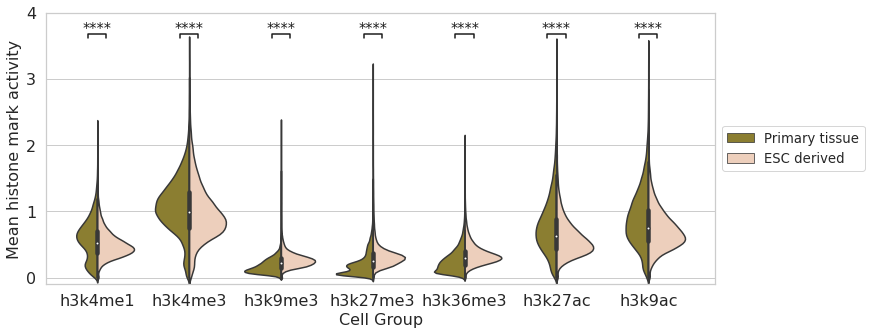

In [21]:
#how variable is the hist mark across genes that are active/inactive
#good to understand - might point to why repressive marks beat active

#look at histone marlk activity in active genes

#plot expression across the two cell groups
import seaborn as sns
from statannot import add_stat_annotation

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

agg_hist_exp_hist = agg_hist_exp.copy()
#filt to just active
agg_hist_exp_hist = agg_hist_exp_hist[agg_hist_exp_hist['label']==1]
agg_hist_exp_hist.drop(['log2RPKM'], axis=1,inplace=True)
agg_hist_exp_hist.drop(['label'], axis=1,inplace=True)
agg_hist_exp_hist = agg_hist_exp_hist.melt(id_vars=['cell_group'])

# Plot
ax = sns.violinplot(x="variable", y="value", hue="cell_group",
                    palette=pal,split=True,data=agg_hist_exp_hist)
#Mann-Whitney U-Test
import scipy.stats as stats
import statsmodels.stats.multitest as multi
# perform two-sided test.
grps = set(agg_hist_exp_hist['variable'])
p_vals = []
for grp_i in grps:
    x=agg_hist_exp_hist[(agg_hist_exp_hist['variable']==grp_i)&
                        (agg_hist_exp_hist['cell_group']=="ESC derived")]['value']
    y=agg_hist_exp_hist[(agg_hist_exp_hist['variable']==grp_i)&
                        (agg_hist_exp_hist['cell_group']=="Primary tissue")]['value']
    print(f"{grp_i} Direction ESC derived - Primary tissue: {np.median(x)-np.median(y)}")
    mwu = stats.mannwhitneyu(x=x,y=y,alternative = 'two-sided')
    p_vals.append(mwu[1])
p_vals_adj = multi.multipletests(p_vals,method='fdr_bh')[1]
print("adjusted p-values: ", p_vals_adj)

mx_vl = agg_hist_exp_hist['value'].max()+0.08

# add MWUT annotations
# test 1
x1, x2 = -0.1, 0.1   
y, h, col = mx_vl, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 2
x1, x2 = x1+1, x2+1
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 3
x1, x2 = x1+1, x2+1   
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 4
x1, x2 = x1+1, x2+1   
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 5
x1, x2 = x1+1, x2+1   
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 6
x1, x2 = x1+1, x2+1   
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 7
x1, x2 = x1+1, x2+1  
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('Mean histone mark activity',fontsize=16)
ax.tick_params(labelsize=16)
ax.set(ylim=(-0.1, 4))

plt.show()


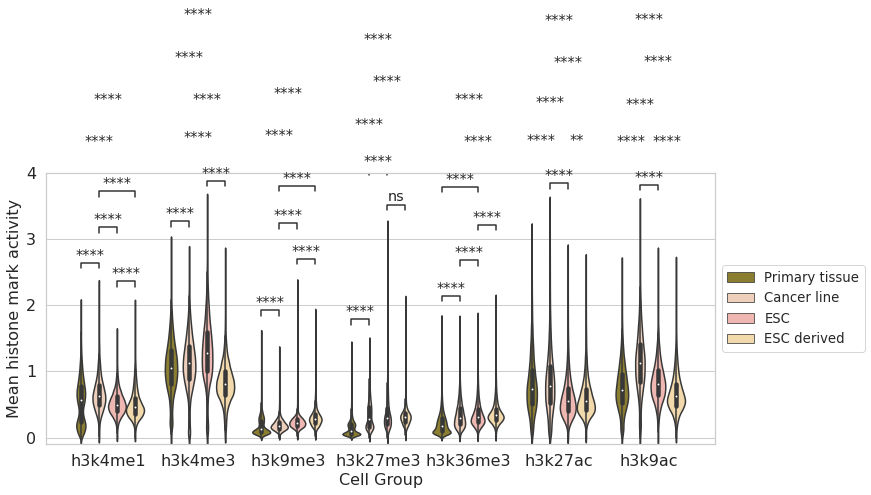

In [23]:
#how variable is the hist mark across genes that are active/inactive
#good to understand - might point to why repressive marks beat active

#look at histone mark activity in active genes

#plot expression across the two cell groups
import seaborn as sns
from statannot import add_stat_annotation

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

agg_hist_exp_sub_hist = agg_hist_exp_sub.copy()
#filt to just active
agg_hist_exp_sub_hist = agg_hist_exp_sub_hist[agg_hist_exp_sub_hist['label']==1]
agg_hist_exp_sub_hist.drop(['log2RPKM'], axis=1,inplace=True)
agg_hist_exp_sub_hist.drop(['label'], axis=1,inplace=True)
agg_hist_exp_sub_hist = agg_hist_exp_sub_hist.melt(id_vars=['cell_group'])

# Plot
ax = sns.violinplot(x="variable", y="value", hue="cell_group",
                    palette=pal,data=agg_hist_exp_sub_hist)
add_stat_annotation(ax, data=agg_hist_exp_sub_hist, x="variable", y="value", hue="cell_group",
                    #order=order,
                    box_pairs=[(("h3k4me1", "Primary tissue"), ("h3k4me1", "Cancer line")),
                               (("h3k4me1", "Primary tissue"), ("h3k4me1", "ESC")),
                               (("h3k4me1", "Primary tissue"), ("h3k4me1", "ESC derived")),
                               (("h3k4me1", "Cancer line"), ("h3k4me1", "ESC")),
                               (("h3k4me1", "Cancer line"), ("h3k4me1", "ESC derived")),
                               (("h3k4me1", "ESC"), ("h3k4me1", "ESC derived")),
                               
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "Cancer line")),
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "ESC")),
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "ESC derived")),
                               (("h3k4me3", "Cancer line"), ("h3k4me3", "ESC")),
                               (("h3k4me3", "Cancer line"), ("h3k4me3", "ESC derived")),
                               (("h3k4me3", "ESC"), ("h3k4me3", "ESC derived")),
                               
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "Cancer line")),
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "ESC")),
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "ESC derived")),
                               (("h3k9me3", "Cancer line"), ("h3k9me3", "ESC")),
                               (("h3k9me3", "Cancer line"), ("h3k9me3", "ESC derived")),
                               (("h3k9me3", "ESC"), ("h3k9me3", "ESC derived")),
                            
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "Cancer line")),
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "ESC")),
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "ESC derived")),
                               (("h3k27me3", "Cancer line"), ("h3k27me3", "ESC")),
                               (("h3k27me3", "Cancer line"), ("h3k27me3", "ESC derived")),
                               (("h3k27me3", "ESC"), ("h3k27me3", "ESC derived")),
                               
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "Cancer line")),
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "ESC")),
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "ESC derived")),
                               (("h3k36me3", "Cancer line"), ("h3k36me3", "ESC")),
                               (("h3k36me3", "Cancer line"), ("h3k36me3", "ESC derived")),
                               (("h3k36me3", "ESC"), ("h3k36me3", "ESC derived")),
                               
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "Cancer line")),
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "ESC")),
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "ESC derived")),
                               (("h3k27ac", "Cancer line"), ("h3k27ac", "ESC")),
                               (("h3k27ac", "Cancer line"), ("h3k27ac", "ESC derived")),
                               (("h3k27ac", "ESC"), ("h3k27ac", "ESC derived")),
                               
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "Cancer line")),
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "ESC")),
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "ESC derived")),
                               (("h3k9ac", "Cancer line"), ("h3k9ac", "ESC")),
                               (("h3k9ac", "Cancer line"), ("h3k9ac", "ESC derived")),
                               (("h3k9ac", "ESC"), ("h3k9ac", "ESC derived")),
                              ],
                    test='Mann-Whitney', text_format='star',loc='inside',verbose=0,
                    comparisons_correction='bonferroni')#doesn't accept BH
# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('Mean histone mark activity',fontsize=16)
ax.tick_params(labelsize=16)
ax.set(ylim=(-0.1, 4))

plt.show()


When we consider only the genes that are highly expressed: 
* Primary tissue cells have greater histone mark activity in **all the active promoter marks** h3k27ac, h3k4me3 and h3k9ac.
* ESC derived cells have greater histone mark activity in **all the repressive marks** h3k27me3 and h3k9me3

This association was not present when considering all genes. It is likely that this increased activity will have lead to the increased performance in the model on the consecutive marks and cell types.

When we look at the 4 groups Cancert line, Primary tissue, ESC and ESC derived we notice:

**Repressive marks**
* ESC and ESC derived cells have higher histone mark activity in the repressive marks h3k27me3 and h3k9me3 than Primary tissue and Cancer lines. 
* ESC derived cells have significantly higher activity than ESC cells in h3k9me3 but not h3k27me3. 
* Primary tissue also has significantly lower acitivty in the two repressive marks than Cancer lines.
* Order of incressing activity - Primary tissue < Cancer line < ESC < ESC derived

**Active Promoter marks**
* Primary tissue and Cancer lines have greater activity in some of the active promoter marks (h3k27ac for both) and (h3k9ac for cancer lines) but not h3k4me3 when compared to ESC but for all when compared to ESC derived h3k27ac, h3k4me3 and h3k9ac.
* Overall, in these marks, there appears to be more activity in Cancer lines than primary tissue - maybe to do with epithelial-to-mesenchymal transition (EMT) occurring in the cancer lines? Or jsut their hetrogeneity?
* Also, overall, in these marks, there is more activity in ESC than ESC derived cells.

This all reconfirms what the results of the ML performances showed.

What if we look at genes which aren't expressed:

h3k27ac Direction ESC derived - Primary tissue: 0.15861851500000002
h3k4me1 Direction ESC derived - Primary tissue: 0.135482515
h3k9me3 Direction ESC derived - Primary tissue: 0.0980125
h3k4me3 Direction ESC derived - Primary tissue: 0.12538391
h3k36me3 Direction ESC derived - Primary tissue: 0.14530992050000002
h3k27me3 Direction ESC derived - Primary tissue: 0.04627981000000003
h3k9ac Direction ESC derived - Primary tissue: 0.17044413500000005
adjusted p-values:  [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.27347639e-289
 0.00000000e+000 0.00000000e+000 0.00000000e+000]


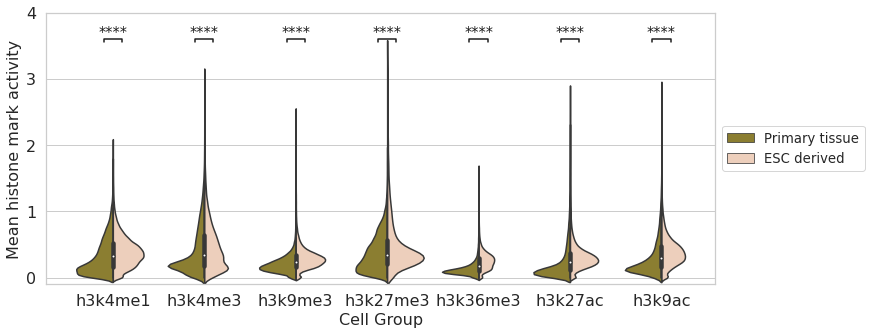

In [22]:
#how variable is the hist mark across genes that are active/inactive
#good to understand - might point to why repressive marks beat active

#look at histone marlk activity in active genes

#plot expression across the two cell groups
import seaborn as sns
from statannot import add_stat_annotation

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

agg_hist_exp_hist = agg_hist_exp.copy()
#filt to just active
agg_hist_exp_hist = agg_hist_exp_hist[agg_hist_exp_hist['label']==0]
agg_hist_exp_hist.drop(['log2RPKM'], axis=1,inplace=True)
agg_hist_exp_hist.drop(['label'], axis=1,inplace=True)
agg_hist_exp_hist = agg_hist_exp_hist.melt(id_vars=['cell_group'])

# Plot
ax = sns.violinplot(x="variable", y="value", hue="cell_group",
                    palette=pal,split=True,data=agg_hist_exp_hist)
#Mann-Whitney U-Test
import scipy.stats as stats
import statsmodels.stats.multitest as multi
# perform two-sided test.
grps = set(agg_hist_exp_hist['variable'])
p_vals = []
for grp_i in grps:
    x=agg_hist_exp_hist[(agg_hist_exp_hist['variable']==grp_i)&
                        (agg_hist_exp_hist['cell_group']=="ESC derived")]['value']
    y=agg_hist_exp_hist[(agg_hist_exp_hist['variable']==grp_i)&
                        (agg_hist_exp_hist['cell_group']=="Primary tissue")]['value']
    print(f"{grp_i} Direction ESC derived - Primary tissue: {np.median(x)-np.median(y)}")
    mwu = stats.mannwhitneyu(x=x,y=y,alternative = 'two-sided')
    p_vals.append(mwu[1])
p_vals_adj = multi.multipletests(p_vals,method='fdr_bh')[1]
print("adjusted p-values: ", p_vals_adj)

mx_vl = agg_hist_exp_hist['value'].max()+0.08

# add MWUT annotations
# test 1
x1, x2 = -0.1, 0.1   
y, h, col = mx_vl, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 2
x1, x2 = x1+1, x2+1
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 3
x1, x2 = x1+1, x2+1   
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 4
x1, x2 = x1+1, x2+1   
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 5
x1, x2 = x1+1, x2+1   
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 6
x1, x2 = x1+1, x2+1   
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# test 7
x1, x2 = x1+1, x2+1  
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('Mean histone mark activity',fontsize=16)
ax.tick_params(labelsize=16)
ax.set(ylim=(-0.1, 4))

plt.show()


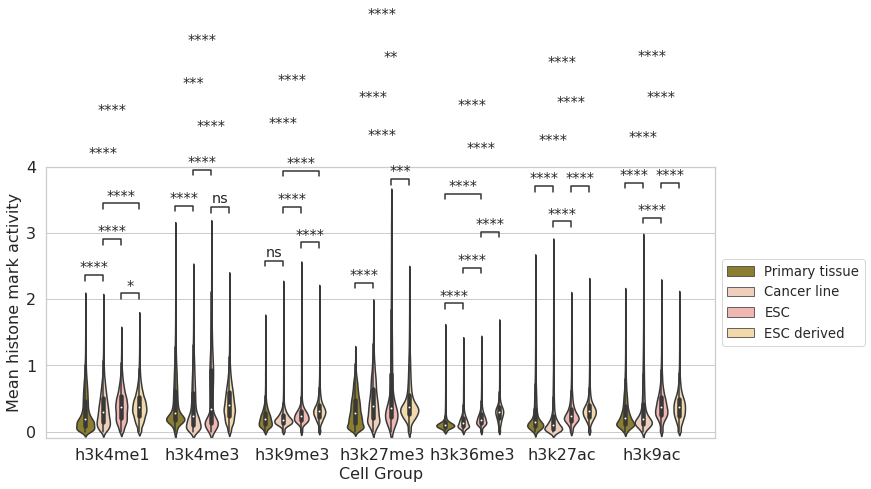

In [24]:
#how variable is the hist mark across genes that are active/inactive
#good to understand - might point to why repressive marks beat active

#look at histone mark activity in active genes

#plot expression across the two cell groups
import seaborn as sns
from statannot import add_stat_annotation

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

agg_hist_exp_sub_hist = agg_hist_exp_sub.copy()
#filt to just active
agg_hist_exp_sub_hist = agg_hist_exp_sub_hist[agg_hist_exp_sub_hist['label']==0]
agg_hist_exp_sub_hist.drop(['log2RPKM'], axis=1,inplace=True)
agg_hist_exp_sub_hist.drop(['label'], axis=1,inplace=True)
agg_hist_exp_sub_hist = agg_hist_exp_sub_hist.melt(id_vars=['cell_group'])

# Plot
ax = sns.violinplot(x="variable", y="value", hue="cell_group",
                    palette=pal,data=agg_hist_exp_sub_hist)
add_stat_annotation(ax, data=agg_hist_exp_sub_hist, x="variable", y="value", hue="cell_group",
                    #order=order,
                    box_pairs=[(("h3k4me1", "Primary tissue"), ("h3k4me1", "Cancer line")),
                               (("h3k4me1", "Primary tissue"), ("h3k4me1", "ESC")),
                               (("h3k4me1", "Primary tissue"), ("h3k4me1", "ESC derived")),
                               (("h3k4me1", "Cancer line"), ("h3k4me1", "ESC")),
                               (("h3k4me1", "Cancer line"), ("h3k4me1", "ESC derived")),
                               (("h3k4me1", "ESC"), ("h3k4me1", "ESC derived")),
                               
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "Cancer line")),
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "ESC")),
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "ESC derived")),
                               (("h3k4me3", "Cancer line"), ("h3k4me3", "ESC")),
                               (("h3k4me3", "Cancer line"), ("h3k4me3", "ESC derived")),
                               (("h3k4me3", "ESC"), ("h3k4me3", "ESC derived")),
                               
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "Cancer line")),
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "ESC")),
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "ESC derived")),
                               (("h3k9me3", "Cancer line"), ("h3k9me3", "ESC")),
                               (("h3k9me3", "Cancer line"), ("h3k9me3", "ESC derived")),
                               (("h3k9me3", "ESC"), ("h3k9me3", "ESC derived")),
                            
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "Cancer line")),
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "ESC")),
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "ESC derived")),
                               (("h3k27me3", "Cancer line"), ("h3k27me3", "ESC")),
                               (("h3k27me3", "Cancer line"), ("h3k27me3", "ESC derived")),
                               (("h3k27me3", "ESC"), ("h3k27me3", "ESC derived")),
                               
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "Cancer line")),
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "ESC")),
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "ESC derived")),
                               (("h3k36me3", "Cancer line"), ("h3k36me3", "ESC")),
                               (("h3k36me3", "Cancer line"), ("h3k36me3", "ESC derived")),
                               (("h3k36me3", "ESC"), ("h3k36me3", "ESC derived")),
                               
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "Cancer line")),
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "ESC")),
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "ESC derived")),
                               (("h3k27ac", "Cancer line"), ("h3k27ac", "ESC")),
                               (("h3k27ac", "Cancer line"), ("h3k27ac", "ESC derived")),
                               (("h3k27ac", "ESC"), ("h3k27ac", "ESC derived")),
                               
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "Cancer line")),
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "ESC")),
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "ESC derived")),
                               (("h3k9ac", "Cancer line"), ("h3k9ac", "ESC")),
                               (("h3k9ac", "Cancer line"), ("h3k9ac", "ESC derived")),
                               (("h3k9ac", "ESC"), ("h3k9ac", "ESC derived")),
                              ],
                    test='Mann-Whitney', text_format='star',loc='inside',verbose=0,
                    comparisons_correction='bonferroni')#doesn't accept BH
# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('Mean histone mark activity',fontsize=16)
ax.tick_params(labelsize=16)
ax.set(ylim=(-0.1, 4))

plt.show()


When we consider only the genes that are not expressed, ESC derived cells had higher histone mark activity across all marks

This holds when split into 4 groups, ESC and ESC derived have highert activity than primary tissue and cancer lines. 


We want stems cells to be able to express diff genes to differentiate so you will see more open chrom
Maybe the more hist mark actiivty makes sense under this idea
We know chromatin more open in ESC before diff

Other mechanism on top of hist mod contributes to reg in less differentiated cells, why perf worse in less diff cells

In literature:

* you have genome-wide broad H3K27ac domains before zygotic genome activation and then changes extensively, [Dynamics of histone acetylation during human early embryogenesis](https://www.nature.com/articles/s41421-022-00514-y)
* Gives the same opinion that more H3K27ac in less diferentiated cells (early embryo cells)

## Chromoformer results

In [6]:
#load chromoformer res
import pandas as pd
import pathlib
from epi_to_express.constants import(
    ASSAYS,
    SAMPLES,
    SAMPLE_IDS)

PRED_PATH = pathlib.Path("./model_results/predictions")

losses_chrom = pd.read_csv(f"{PRED_PATH}/chromoformer_blind_test.csv", sep='\t')
#also loadf perf using all hist marks
losses_chrom_all = pd.read_csv(f"{PRED_PATH}/chromoformer_all_hist_perf.csv")

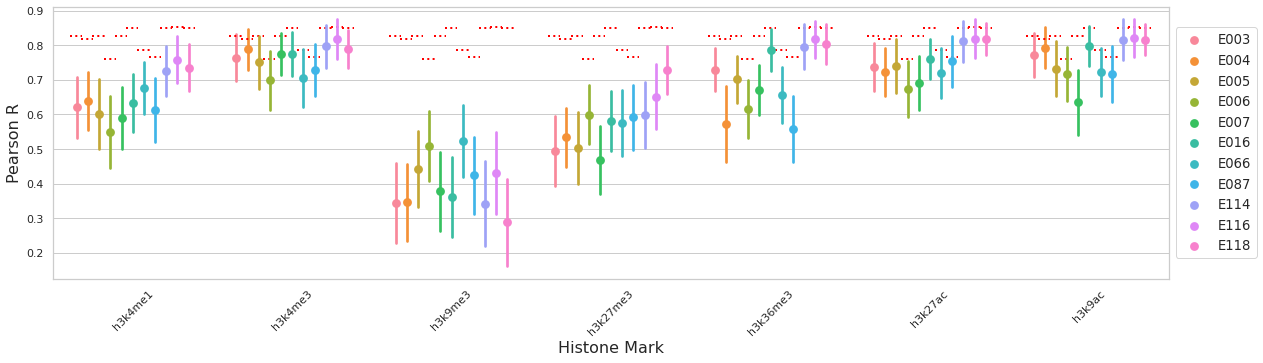

In [63]:
#plot
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 5)})
#sns.set_palette("colorblind")
#same wesanderson palette as used in R plots
extended_palette = ["#9A8822","#F5CDB4","#F8AFA8",
                    "#FDDDA0","#74A089","#85D4E3",
                    #added extra to make 7
                    '#78A2CC']
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

perf_plt = sns.pointplot(hue = "cell",       
            y = "Pearson_R",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses_chrom, ci="sd",join=False,
            dodge=0.7
                      )
#add perf of chromoformer for each cell type
cell_mean_perf = losses_chrom_all.groupby(['cell'])['Pearson_R'].mean().values
for ind,asy_i in enumerate(ASSAYS):
    for c_ind,cell_i in enumerate(SAMPLE_IDS):
        perf_plt.axhline(y=cell_mean_perf[c_ind], 
                         lw=2, c='red', ls=':', 
                         xmin=(ind/len(ASSAYS))+.015+((c_ind)/len(SAMPLE_IDS))/9, 
                         xmax=(ind/len(ASSAYS))+.026+((c_ind)/len(SAMPLE_IDS))/9)
    
# Put the legend out of the figure
perf_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
perf_plt.tick_params(axis='x', rotation=45)

perf_plt.set_xlabel('Histone Mark',fontsize=16)
perf_plt.set_ylabel('Pearson R',fontsize=16)
perf_plt.tick_params(labelsize=11)

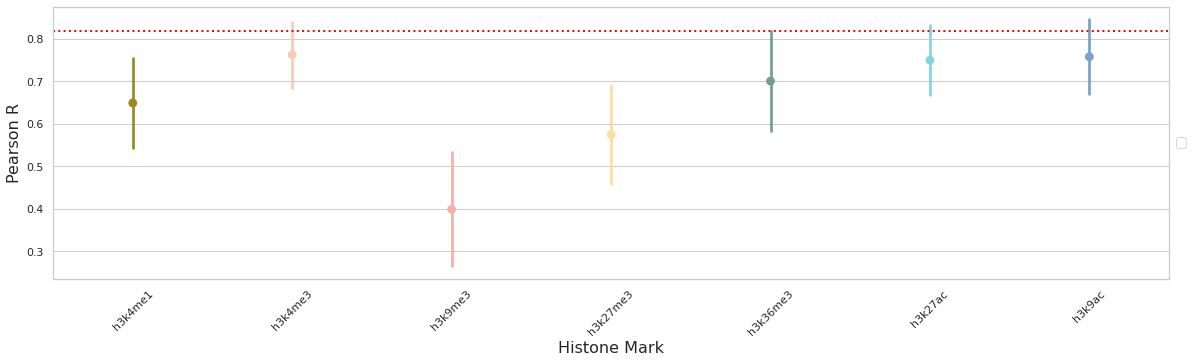

In [66]:
#plot
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 5)})
#same wesanderson palette as used in R plots
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

perf_plt = sns.pointplot(       
            y = "Pearson_R",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses_chrom, ci="sd",join=False,
            dodge=0.3, palette=pal)
#add in mean perf of chromoformer using all hist marks
mean_perf = losses_chrom_all['Pearson_R'].mean()
perf_plt.axhline(y=mean_perf, 
                 lw=2, c='red', ls=':', 
                 xmin=0,xmax=1)
# Put the legend out of the figure
perf_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
perf_plt.tick_params(axis='x', rotation=45)

perf_plt.set_xlabel('Histone Mark',fontsize=16)
perf_plt.set_ylabel('Pearson R',fontsize=16)
perf_plt.tick_params(labelsize=11)

Top 3:

1. h3k4me3 - indicative of a promoter region [ref](https://science.sciencemag.org/content/366/6469/1134.fullref-11)
2. h3k9ac - associated with active promoters [ref](https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-13-424)
3. h3k27ac - active enhancers and promoters [ref](https://www.frontiersin.org/articles/10.3389/fgene.2020.00817/full)

The rest:

4. h3k36me3 - heterochromatin [ref](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3166828/)    
5. h3k4me1 - commonly associated with distal enhancers [ref](https://www.frontiersin.org/articles/10.3389/fcell.2020.00289/full)
6. h3k27me3 - repressive mark [ref](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009368)
7. h3k9me3 - repressive mark - associated with heterochromatin - initially non-repressive, bookmarks promoters for compaction [ref](https://doi.org/10.1038/s41556-020-0536-6)

* Compared to the other model, the biggest changes in rank are for  h3k9me3 which dropped from 3 best to 7 best predictive mark and h3k27ac which increased from 5 to 3 best (there is very little performance difference in the first 3)
* Performance of incorporating all marks in the chromoformer model only marginally increases Perason R scores but does consistently increase it. I think it would be worth testing training chromoformer on combinations of marks. I was thinking of combining h3k4me3 and h3k9ac with active enhancer/hetrochromatin marks (h3k27ac, h3k36me3, h3k4me1, h3k27me3, h3k9me3). The idea would be to test if we can obtain the same performance with just 2 marks as using all. This also avoids testing all combinations which would take a long time.